## HR Analytics

Predict employee promotion using a dataset available here: https://datahack.analyticsvidhya.com/contest/wns-analytics-hackathon-2018-1/

### Contents

* [I. Notebook setup](#setup)
* [II. Load data & EDA](#eda)
* [III. Modeling](#model)
    * [a. Single decision tree](#single-dt)
    * [b. With upsampled data](#upsample)
    * [c. Random forest](#forest)

### I. Notebook setup <a id="setup" /a>

In [20]:
import os

import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

from graphviz import Source

In [8]:
%matplotlib inline

SEED = 42

In [9]:
def plot_feature_importance(features, dtree):
    """
    Display a bar chart of the importance of each feature 
    in a decision tree 
    
    Args:
        features: the feature names 
        dtree: the trained decision tree
        
    Returns:
        None
    """
    
    # map each feature name to its importance in the tree
    d = {f: i for f, i 
         in zip(features, dtree.feature_importances_)}
    
    # create a dataframe from the map
    importances = pd.DataFrame.from_dict(d, orient="index")
    importances.rename(columns={0: "gini-importance"}, inplace=True)
    
    # sort by importance and generate the graph
    sorted_importances = importances.sort_values(by="gini-importance")
    _ = sorted_importances.plot(kind="bar", figsize=(10, 5))

In [10]:
VIZ_DIR = "viz"

def write_tree_viz(dtree, features, filename):
    """
    Write a visualization of a decision tree to disk
    
    Args:
        dtree: the tree to visualize
        features: the names of the tree features
        filename: the name of the image file to write
        
    Returns:
        None
    """
    
    viz = tree.export_graphviz(
            dtree, 
            out_file=None, 
            feature_names=features
    )
    
    graph = Source(viz)
    png_bytes = graph.pipe(format="png")

    path = os.path.join(VIZ_DIR, filename)
    with open(path, "wb") as f:
        f.write(png_bytes)

In [11]:
def evaluate_model(predictions, y_true):
    """
    Print some evaluation metrics
    
    Args:
        predictions - the model predictions
        y_true - the true values
        
    Returns:
        None
    """
    f1 = f1_score(y_test, pred)
    
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / len(y_true)
    
    percent_positive = (tp + fp) / len(y_true) * 100
    
    out = f"""
    F1 score: {f1:.2}
    Accuracy: {acc:.2}
    
    True Positives: {tp}
    False Positives: {fp}
    True Negatives: {tn}
    False Negatives: {fn}
    
    Positive predictions: {percent_positive:.2}%
    
    Precision: {precision:.2}
    Recall / Sensitivity: {recall:.2}
    """
    
    print(out)

In [12]:
def upsample_data(df, percent: float):
    """
    Upsample the minority class
    
    Args:
        df - the dataframe to resample
        percent - the percent of the data that will consist of the minority class
    
    Returns:
        DataFrame with bootstrapped minority class
    """
    
    # split the dataframe by class
    df_major = df[df.is_promoted == 0]
    df_minor = df[df.is_promoted == 1]
    
    # determine how many of the minority class to generate
    samples = int(percent * df_major.shape[0])

    # upsample the minority class
    df_minor_up = resample(df_minor, 
                           replace=True, 
                           n_samples=samples, 
                           random_state=SEED)
    
    # combine the classes
    return pd.concat([df_major, df_minor_up])

In [13]:
def get_train_test_sets(df):
    """
    Generates train and test sets and converts categorical features to dummies 
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    
    X = pd.get_dummies(df.drop("is_promoted", axis=1))
    y = df["is_promoted"]
    
    return train_test_split(X, y, test_size=0.2, random_state=SEED)

In [14]:
def grow_tree(X_train, y_train, param_grid, model=DecisionTreeClassifier()):
    
    clf = GridSearchCV(model, 
                       params, 
                       n_jobs=2, 
                       cv=5, 
                       scoring="f1")

    clf.fit(X_train, y_train)
    return clf

### Load data & EDA <a id="eda" /a>

Load the data and examine the data types and first few rows.

In [41]:
df = pd.read_csv("data/train_LZdllcl.csv")

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


In [37]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


Examine summary statistics and distributions for the numeric colimns.

In [38]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


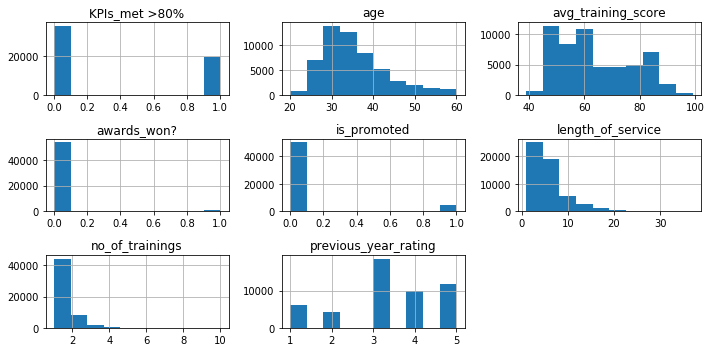

In [46]:
df.hist(figsize=(10, 5))
plt.tight_layout()

Nothing above looks too surprising. The mean of *is_promoted* shows that 8.5% of employees in the dataset are promoted, so there is a class imbalance, as expected.

Let's make sure that *employee_id* is always unique and then drop that feature.

In [39]:
df.employee_id.nunique() == df.employee_id.count()

True

In [42]:
df = df.drop("employee_id", axis=1)

There are a few thousand missing values for *previous_year_rating*. We'll impute the mean so that the models below don't blow up.

In [43]:
df["previous_year_rating"].fillna(3, inplace=True)

Examine categorical features.

In [49]:
df.describe(include="O")

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


As above, nothing looks too surprising here. There are a large number of regions.

### Modeling <a id="model" /a>

Split the data into training and holdout sets.

In [44]:
X = pd.get_dummies(df.drop("is_promoted", axis=1))
y = df["is_promoted"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#### a. Single decision tree <a id="single-dt" /a>

Let's see what kind of performance we can achieve with a single tree. We'll set a max height of 8 to start. 

In [59]:
dt = DecisionTreeClassifier(max_depth=8)

In [60]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

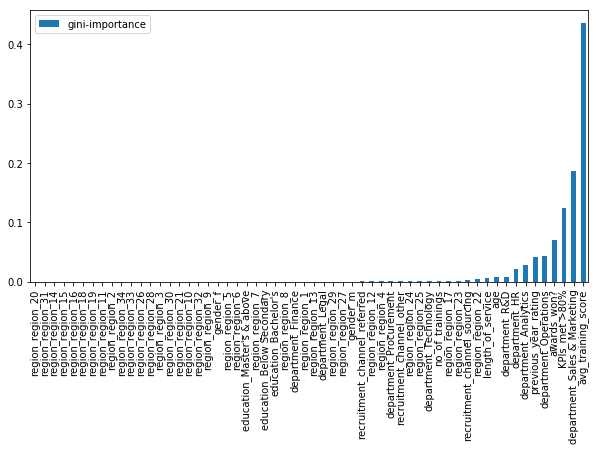

In [71]:
plot_feature_importance(X.columns, dt)

In [86]:
write_tree_viz(dt, X.columns, "tree_initial.png")

In [127]:
evaluate_model(pred, y_test)


    F1 score: 0.37
    Accuracy: 0.93
    
    True Positives: 214
    False Positives: 32
    True Negatives: 10022
    False Negatives: 694
    
    Positive predictions: 2.2%
    
    Precision: 0.87
    Recall / Sensitivity: 0.24
    


So the initial model is predicting the negative class in 98% of cases, resulting in poor recall and so a poor f1 score. Can we tweak the parameters to produce a better model?  

In [129]:
params = { 
    "max_depth": range(2, 20, 2),
    "min_impurity_decrease": [0, 0.01, 0.005, 0.0025],
    "min_samples_split": range(2, 20, 2),
}

clf = GridSearchCV(DecisionTreeClassifier(), 
                   params, 
                   n_jobs=2, 
                   cv=5, 
                   scoring="f1")

clf.fit(X_train, y_train)
dt_best = clf.best_estimator_

clf.best_params_

{'max_depth': 18, 'min_impurity_decrease': 0, 'min_samples_split': 18}

In [131]:
pred = dt_best.predict(X_test)
evaluate_model(pred, y_test)


    F1 score: 0.48
    Accuracy: 0.93
    
    True Positives: 330
    False Positives: 146
    True Negatives: 9908
    False Negatives: 578
    
    Positive predictions: 4.3%
    
    Precision: 0.69
    Recall / Sensitivity: 0.36
    


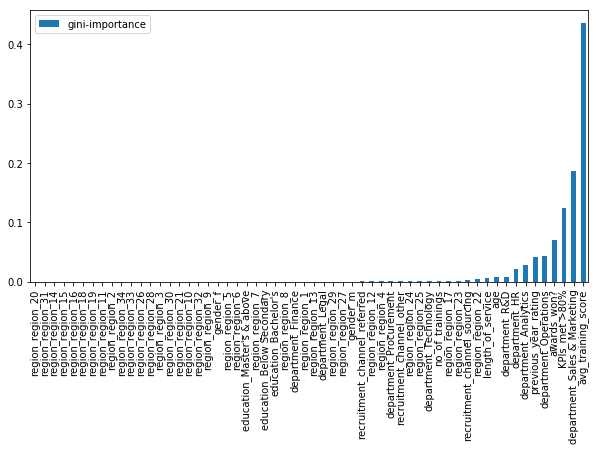

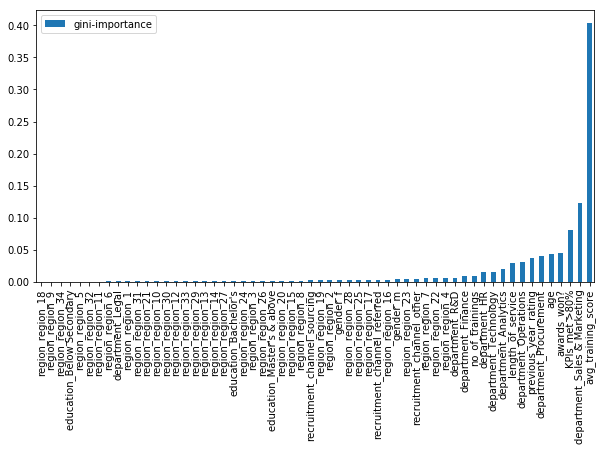

In [137]:
plot_feature_importance(X.columns, dt)
plot_feature_importance(X.columns, dt_best)

In [133]:
write_tree_viz(dt_best, X.columns, "tree_best.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.868437 to fit


The best model over these parameters has a max height of 18 and stops splitting at 18 samples. 

The number of positive predictions has nearly doubled, and the recall has improved by 50%, at the expense of precision. Overall, the f1 score is now at 48%.

This model is assigning more importance to age and certain departments.

Can we further improve recall by addressing the class imbalance?

#### b. With upsampled data <a id="upsample" /a>

In [178]:
df_up = upsample_data(df, .25)

X_train, X_test, y_train, y_test = get_train_test_sets(df_up)

In [179]:
clf = GridSearchCV(DecisionTreeClassifier(), 
                   params, 
                   n_jobs=2, 
                   cv=5, 
                   scoring="f1")

clf.fit(X_train, y_train)
dt_best = clf.best_estimator_

clf.best_params_

{'max_depth': 18, 'min_impurity_decrease': 0, 'min_samples_split': 2}

In [180]:
pred = dt_best.predict(X_test)
evaluate_model(dt_best, y_test)


    F1 score: 0.71
    Accuracy: 0.89
    
    True Positives: 1626
    False Positives: 439
    True Negatives: 9565
    False Negatives: 905
    
    Positive predictions: 1.6e+01%
    
    Precision: 0.79
    Recall / Sensitivity: 0.64
    


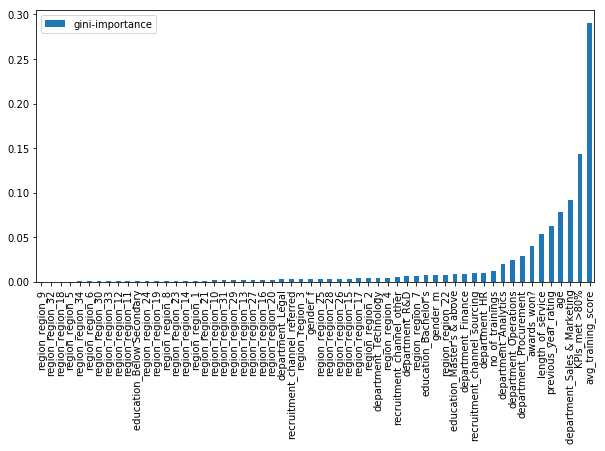

In [181]:
plot_feature_importance(X_train.columns, dt_best)

Upsampling the minority class to 25% increased the f1 score to 71%. What if we upsample to 50%? 



In [182]:
df_up = upsample_data(df, .50)

X_train, X_test, y_train, y_test = get_train_test_sets(df_up)

clf = GridSearchCV(DecisionTreeClassifier(), 
                   params, 
                   n_jobs=2, 
                   cv=5, 
                   scoring="f1")

clf.fit(X_train, y_train)
dt_best = clf.best_estimator_

print(clf.best_params_)

pred = dt_best.predict(X_test)
evaluate_model(dt_best, y_test)

{'max_depth': 18, 'min_impurity_decrease': 0, 'min_samples_split': 2}

    F1 score: 0.8
    Accuracy: 0.86
    
    True Positives: 4086
    False Positives: 1134
    True Negatives: 8878
    False Negatives: 944
    
    Positive predictions: 3.5e+01%
    
    Precision: 0.78
    Recall / Sensitivity: 0.81
    


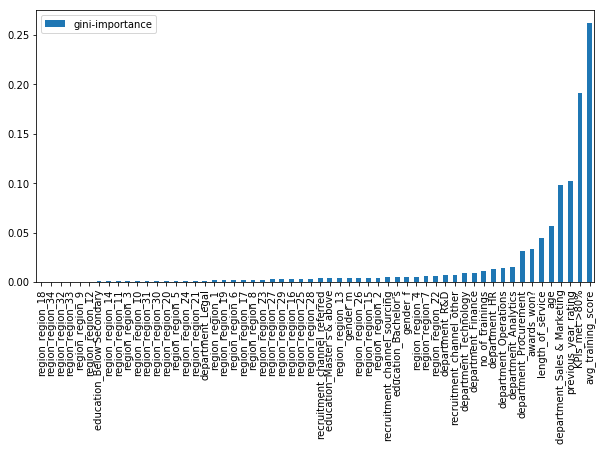

In [183]:
plot_feature_importance(X_train.columns, dt_best)

The model is now predicting the positive class in 35% of cases, and f1 score has increased to 80%. If we keep upsampling, the model will continue to predict more positive cases, and recall and f1 will further improve (I tried it up to 99%). However, the model parameters will remain the same, and we are likely overfitting. Let's move on to multiple trees.

#### c. Random forest

We'll next try random forests with 10, 100 and 200 trees.

In [26]:
df_up = upsample_data(df, .30)

X_train, X_test, y_train, y_test = get_train_test_sets(df_up)

params = { 
#     "max_depth": [20],#range(2, 20, 2),
#     "n_estimators": [10, 100, 200]
}

clf = grow_tree(X_train, y_train, params, model=RandomForestClassifier())

/Users/Bobo/.local/share/virtualenvs/atlantic-elkin-teZAjq8W/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
dt_best = clf.best_estimator_

print(clf.best_params_)

pred = dt_best.predict(X_test)
evaluate_model(dt_best, y_test)

{'max_depth': 18, 'n_estimators': 200}

    F1 score: 0.73
    Accuracy: 0.9
    
    True Positives: 1787
    False Positives: 78
    True Negatives: 9929
    False Negatives: 1243
    
    Positive predictions: 1.4e+01%
    
    Precision: 0.96
    Recall / Sensitivity: 0.59
    


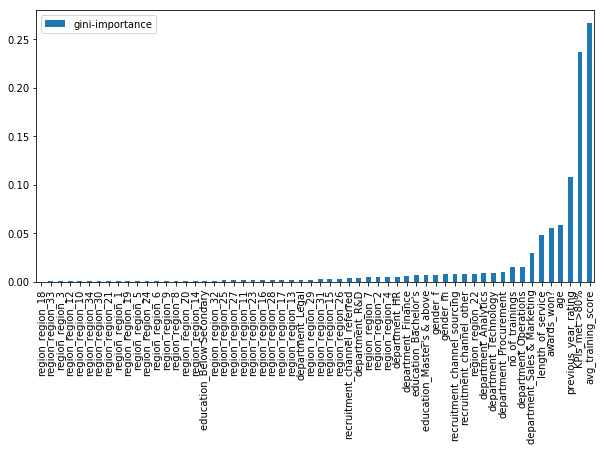

In [229]:
plot_feature_importance(X_train.columns, dt_best)

### Gradient Boosted Tree

In [58]:
# X_train, X_test, y_train, y_test = get_train_test_sets(df_up)
df_up = upsample_data(df, .30)
X_train, X_test, y_train, y_test = get_train_test_sets(df_up)
params = { 
    "max_depth": range(3, 8),
    "n_estimators": [100, 200]
}

clf = grow_tree(X_train, y_train, params, model=GradientBoostingClassifier())

In [59]:
dt_best = clf.best_estimator_

print(clf.best_params_)

pred = dt_best.predict(X_test)
evaluate_model(dt_best, y_test)

{'max_depth': 7, 'n_estimators': 200}

    F1 score: 0.74
    Accuracy: 0.89
    
    True Positives: 1986
    False Positives: 325
    True Negatives: 9682
    False Negatives: 1044
    
    Positive predictions: 1.8e+01%
    
    Precision: 0.86
    Recall / Sensitivity: 0.66
    


### Test

The random forest results look good. Let's run on the test set and submit the results for evaluation.

In [60]:
df_test = pd.read_csv("data/test_2umaH9m.csv")
df_test = pd.get_dummies(df_test)
df_test = df_test.drop("employee_id", axis=1)
df_test["previous_year_rating"].fillna(3, inplace=True)
df_test.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Analytics,department_Finance,department_HR,...,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,1,24,3.0,1,1,0,77,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,1,31,3.0,5,0,0,51,0,0,1,...,0,0,1,0,0,1,0,1,0,0
2,1,31,1.0,4,0,0,47,0,0,0,...,0,0,1,0,0,0,1,1,0,0
3,3,31,2.0,9,0,0,65,0,0,0,...,0,0,1,0,0,1,0,1,0,0
4,1,30,4.0,7,0,0,61,0,1,0,...,0,0,1,0,0,0,1,0,0,1


In [61]:
pred = dt_best.predict(df_test)

In [62]:
# add the employee_id back, per the sample submission
employees = pd.read_csv("data/test_2umaH9m.csv")[["employee_id"]]
res = pd.concat([employees, pd.DataFrame(pred, columns=["is_promoted"])], axis=1)
res.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [63]:
res.to_csv("data/predictions.csv", index=None)